In [1]:
# Toy CNN classifier for Dogs and Cats.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt

plt.ion()

In [36]:
# Read data and apply transforms
data_dir = '../Data/dogscats'
batch_size = 10
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.5, 0.5, 0.5])
image_transforms = {'train' : transforms.Compose([
    transforms.RandomResizedCrop(64, scale=(0.4, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)]),
                    'valid' : transforms.Compose([
                        transforms.Resize((64, 64)),
                        transforms.ToTensor(),
                        transforms.Normalize(mean, std)
                    ])}
image_data = {x : datasets.ImageFolder(os.path.join(data_dir, x),
                                      transform=image_transforms[x])
             for x in ['train', 'valid']}
image_loaders = {x : DataLoader(image_data[x], batch_size=batch_size, 
                                shuffle=True)
               for x in ['train', 'valid']}
class_names = image_data['train'].classes
num_classes = len(class_names)

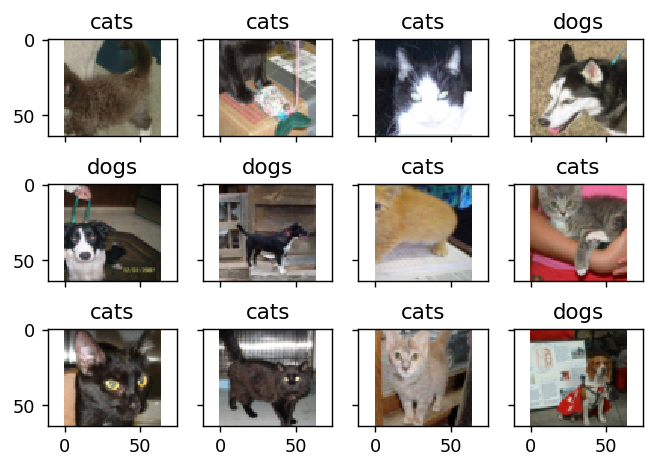

In [37]:
# This function takes a FloatTensor img as input, and 
# de-normalizes it. It then converts the shape from
# (C, H, W) to (H, W, C) which is required by imshow()
# This function keeps the output pixel values in [0,1]
# by clipping.
def DenormalizeImage(img, mean, std):
    return np.clip(img.numpy().transpose((1, 2, 0))*std + mean, 0.0, 1.0)

# Display some images in a grid
num_images = 12
num_cols = 4
num_rows = num_images//num_cols + (num_images%num_cols != 0)
f, axes_array = plt.subplots(num_rows, num_cols, sharex='col', sharey='row', 
                             dpi=128)
num_displayed = 0
while (num_displayed != num_images):
    img_batch, classes = next(iter(image_loaders['train']))
    for i in range(len(img_batch)):
        disp_row = num_displayed//num_cols + (num_displayed%num_cols != 0) - 1
        disp_col = num_displayed%num_cols
        axes_array[disp_row, disp_col].imshow(DenormalizeImage(img_batch[i], mean, std))
        axes_array[disp_row, disp_col].set_title(class_names[classes[i]])
        num_displayed += 1
        if (num_displayed == num_images): break

# Increase distance between sub-plots
f.subplots_adjust(hspace=0.5)
plt.show()

In [38]:
C_in = 3

class SimpleCNN(torch.nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=C_in, out_channels=6, 
                               kernel_size=2, stride=2, padding=2)    # Output Shape: [6, 34, 34]
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=1)            # Output Shape: [6, 33, 33]
        self.bn1 = nn.BatchNorm2d(num_features=6)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, 
                               kernel_size=2, stride=2, padding=2)    # Output Shape: [12, 18, 18]
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=1)            # Output Shape: [12, 17, 17]
        self.fc1 = nn.Linear(in_features=12*17*17, 
                             out_features=num_classes)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.bn1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.view(x.size()[0], -1)
        x = self.fc1(x)
        return x

In [54]:
def EvalAccuracy(model, dataloader):
    total_datapoints = 0
    correct_datapoints = 0
    for _, data in enumerate(dataloader, 0):
        inputs, true_labels = data
        outputs = model(Variable(inputs))
        _, prediction = torch.max(outputs.data, dim=1, )
        total_datapoints += prediction.size(0)
        correct_datapoints += (prediction == true_labels).sum()
    if (total_datapoints == 0):
        return 0.0
    else:
        return correct_datapoints/total_datapoints
    

In [55]:
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(image_loaders['train'], 0):
        inputs, labels = data
        inputs, labels = Variable(inputs), Variable(labels)
        optimizer.zero_grad()
        # forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        # backward pass
        loss.backward()
        # parameter update
        optimizer.step()
        # print loss accumulated over every 20 batches
        running_loss += loss.data[0]
        if (i%20 == 19):
            model.eval()
            valid_acc = EvalAccuracy(model, image_loaders['valid'])*100
            model.train()
            print('Epoch {}, Minibatch {}: Loss = {:.4f}, Val acc = {:.2f}'.format(
                epoch + 1, i + 1, running_loss / (batch_size*20), valid_acc))
            running_loss = 0.0

Epoch 1, Minibatch 20: Loss = 0.0707, Val acc = 50.00
Epoch 1, Minibatch 40: Loss = 0.0716, Val acc = 50.00
Epoch 1, Minibatch 60: Loss = 0.0652, Val acc = 53.00
Epoch 1, Minibatch 80: Loss = 0.0734, Val acc = 52.50
Epoch 2, Minibatch 20: Loss = 0.0711, Val acc = 63.50
Epoch 2, Minibatch 40: Loss = 0.0696, Val acc = 66.00
Epoch 2, Minibatch 60: Loss = 0.0698, Val acc = 63.00
Epoch 2, Minibatch 80: Loss = 0.0662, Val acc = 57.50
Epoch 3, Minibatch 20: Loss = 0.0649, Val acc = 58.00
Epoch 3, Minibatch 40: Loss = 0.0695, Val acc = 62.50
Epoch 3, Minibatch 60: Loss = 0.0641, Val acc = 65.50
Epoch 3, Minibatch 80: Loss = 0.0673, Val acc = 62.00
Epoch 4, Minibatch 20: Loss = 0.0640, Val acc = 62.50
Epoch 4, Minibatch 40: Loss = 0.0681, Val acc = 55.50
Epoch 4, Minibatch 60: Loss = 0.0648, Val acc = 63.50
Epoch 4, Minibatch 80: Loss = 0.0624, Val acc = 63.00
Epoch 5, Minibatch 20: Loss = 0.0662, Val acc = 63.00
Epoch 5, Minibatch 40: Loss = 0.0670, Val acc = 58.50
Epoch 5, Minibatch 60: Loss 